<a href="https://colab.research.google.com/github/shanthisree0315/CSGY-6513_Final_Project_Traffic_Accident_Analysis/blob/main/Traffic_accident_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 39 kB/s 
     |████████████████████████████████| 199 kB 49.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=d454f50f2238b83e998c10702579fee789f1f4aab6071db532ec816a2753ccbc
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


# Read from Kaggle

In [ ]:
! pip install -q kaggle

from google.colab import files

# Upload json file
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list
! kaggle datasets download sobhanmoosavi/us-accidents
! kaggle datasets download darinhawley/us-2021-census-cities-populations-coordinates


Saving kaggle.json to kaggle.json
100% 269M/269M [00:13<00:00, 19.0MB/s]
100% 269M/269M [00:13<00:00, 21.2MB/s]
100% 397k/397k [00:00<00:00, 777kB/s]
100% 397k/397k [00:00<00:00, 776kB/s]


In [ ]:
! unzip /content/us-accidents

Archive:  /content/us-accidents.zip
  inflating: US_Accidents_Dec21_updated.csv  


In [ ]:
! unzip /content/us-2021-census-cities-populations-coordinates

Archive:  /content/us-2021-census-cities-populations-coordinates.zip
  inflating: us2021census.csv        


In [ ]:
import os
import pyspark

conf = pyspark.SparkConf()
# conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.sql.repl.eagerEval.enabled', True)
# conf.set('spark.driver.memory','4g')

sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

%matplotlib inline

In [ ]:
#read accident dataset into a dataframe
accidents_df = spark.read\
              .option("header", True)\
              .option("inferSchema", True)\
              .csv("/content/US_Accidents_Dec21_updated.csv")

In [ ]:
accidents_df.show(5)

+---+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------+-----------+----+----------+----------+-----+-------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|           End_Lat|           End_Lng|       Distance(mi)|         Description|Number|     Street|Side|      City|    County|State|Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|P

In [ ]:
accidents_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(

In [ ]:
#read population 2021 dataset into a dataframe
population_dataset = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("/content/us2021census.csv")
)

In [ ]:
# Imports
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, year, split, desc, lower, explode, regexp_replace, row_number, udf, broadcast, substring, count, avg, sum, min, dayofweek, to_date
from pyspark.sql.types import ArrayType, StringType, BooleanType, IntegerType
from pyspark.sql.window import Window
sqlContext = SQLContext(spark)
sqlContext

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



# Read Data from GCS

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

In [ ]:
# !curl https://sdk.cloud.google.com | bash

In [ ]:
# !gcloud init

In [ ]:
# !gsutil cp gs://usaccidents2021/US_Accidents_Dec21.csv accidents.csv

# Insights:



# 1. Top 10 states with the highest accident count in decreasing order in year 2021

In [ ]:
# Get the accident count per state per year
accidents_df.select(year("Start_Time").alias("Start_Year"))
data_with_year = accidents_df.withColumn("Start_Year", year(accidents_df["Start_Time"]))
data_with_year.registerTempTable("data_with_year")
data_state_acc_count = sqlContext.sql(
    "SELECT Start_Year,State, count(ID) as accidents_count FROM data_with_year group by Start_Year,State "
)
data_state_acc_count

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


Start_Year,State,accidents_count
2017,MO,4026
2016,IA,735
2021,NJ,26002
2016,AZ,2715
2021,WI,187
2016,NJ,3961
2017,OR,1397
2021,AR,7358
2017,DC,293
2021,MN,51164


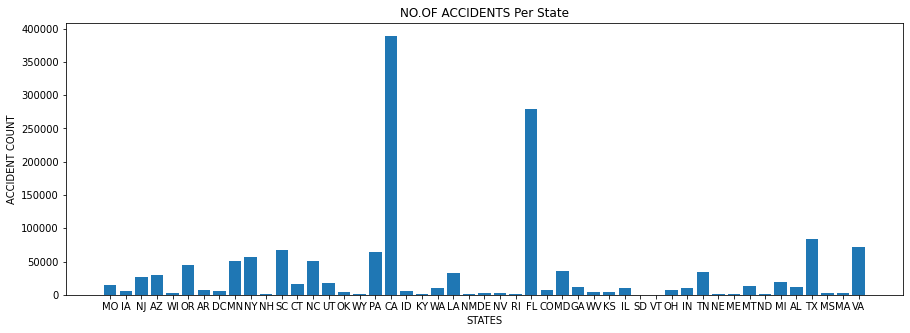

In [ ]:
# Plot accident count per state using Pandas
data_state_acc_count_pd = data_state_acc_count.toPandas()
plt.figure(figsize=(15, 5))
plt.bar(
    data_state_acc_count_pd.State, data_state_acc_count_pd.accidents_count
)

plt.xlabel("STATES")
plt.ylabel("ACCIDENT COUNT")
plt.title("NO.OF ACCIDENTS Per State")
plt.show()

In [ ]:
# Get the top 10 states with accident count in year 2021
data_state_acc_count.registerTempTable("data_state_acc_count")
data_state_acc_count_2021_desc = sqlContext.sql(
    "SELECT Start_Year,State,accidents_count FROM data_state_acc_count where Start_Year = 2021 order by accidents_count desc limit 10"
)
data_state_acc_count_2021_desc.show()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+----------+-----+---------------+
|Start_Year|State|accidents_count|
+----------+-----+---------------+
|      2021|   CA|         388838|
|      2021|   FL|         278395|
|      2021|   TX|          83605|
|      2021|   VA|          71940|
|      2021|   SC|          66813|
|      2021|   PA|          64950|
|      2021|   NY|          56204|
|      2021|   MN|          51164|
|      2021|   NC|          50519|
|      2021|   OR|          45358|
+----------+-----+---------------+



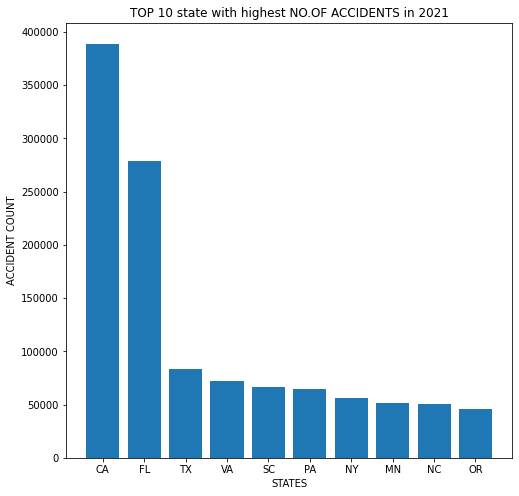

In [ ]:
# top 10 states with accident count in year 2021 using Pandas
data_state_acc_count_2021_desc_pd = data_state_acc_count_2021_desc.toPandas()
plt.figure(figsize=(8, 8))
plt.bar(
    data_state_acc_count_2021_desc_pd.State,
    data_state_acc_count_2021_desc_pd.accidents_count,
)
plt.ylabel("ACCIDENT COUNT")
plt.xlabel("STATES")
plt.title("TOP 10 state with highest NO.OF ACCIDENTS in 2021")
plt.show()

# 2. Top 10 cities with the highest accident count in decreasing order in year 2021

In [ ]:
# Get the top 10 cities with accident count in year 2021
data_with_year.registerTempTable("data_with_year")
city_acc_count_2021 = sqlContext.sql(
    "SELECT Start_Year,State,City, count(ID) as accidents_count_city FROM data_with_year where Start_Year = 2021 \
    group by Start_Year,City,State order by accidents_count_city desc limit 10"
)
city_acc_count_2021.show()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+----------+-----+-----------+--------------------+
|Start_Year|State|       City|accidents_count_city|
+----------+-----+-----------+--------------------+
|      2021|   FL|      Miami|               78875|
|      2021|   FL|    Orlando|               41608|
|      2021|   CA|Los Angeles|               32768|
|      2021|   TX|     Dallas|               24875|
|      2021|   TX|    Houston|               21475|
|      2021|   CA| Sacramento|               15848|
|      2021|   NC|  Charlotte|               15635|
|      2021|   NC|    Raleigh|               15285|
|      2021|   CA|  San Diego|               13776|
|      2021|   TN|  Nashville|               13312|
+----------+-----+-----------+--------------------+



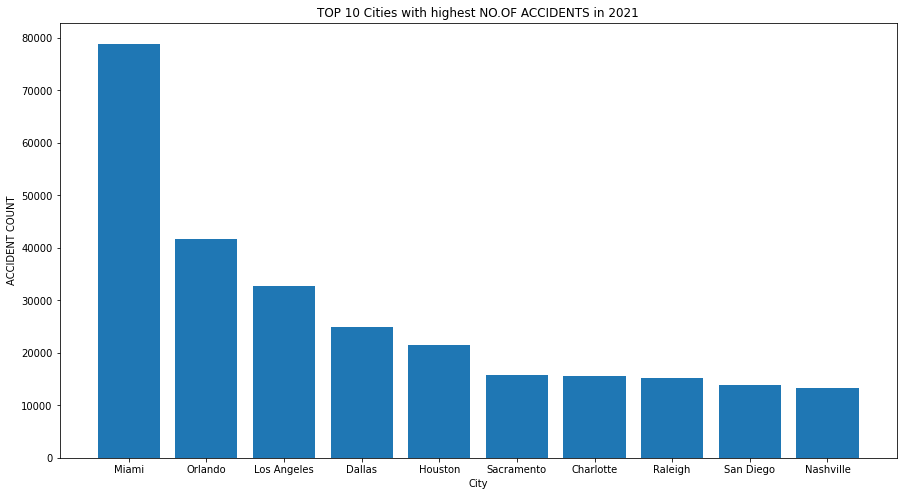

In [ ]:
city_acc_count_2021_pd = city_acc_count_2021.toPandas()
plt.figure(figsize=(15, 8))
plt.bar(city_acc_count_2021_pd.City, city_acc_count_2021_pd.accidents_count_city)

plt.ylabel("ACCIDENT COUNT")
plt.xlabel("City")
plt.title("TOP 10 Cities with highest NO.OF ACCIDENTS in 2021")
plt.show()

# 3. Top 10 states Accident count vs population in the year 2021

In [ ]:
#Spark INNER join of population dataset of top 10 states with accident count of states in the year 2021
population_dataset_state_df = population_dataset.groupBy("State").agg(sum("Population"))
state_acc_count_2021_with_pop = population_dataset_state_df.join(\
                                                                    data_state_acc_count_2021_desc,population_dataset_state_df.State \
                                                                    ==  data_state_acc_count_2021_desc.State,"inner") 
state_acc_count_2021_with_pop.count()

10

In [ ]:
state_acc_count_2021_with_pop.show()

+-----+---------------+----------+-----+---------------+
|State|sum(Population)|Start_Year|State|accidents_count|
+-----+---------------+----------+-----+---------------+
|   SC|        1885431|      2021|   SC|          66813|
|   MN|        4748703|      2021|   MN|          51164|
|   OR|        2989700|      2021|   OR|          45358|
|   VA|        3117984|      2021|   VA|          71940|
|   CA|       33000955|      2021|   CA|         388838|
|   NC|        6017700|      2021|   NC|          50519|
|   PA|        5675852|      2021|   PA|          64950|
|   NY|       13011280|      2021|   NY|          56204|
|   TX|       21096801|      2021|   TX|          83605|
|   FL|       10832913|      2021|   FL|         278395|
+-----+---------------+----------+-----+---------------+



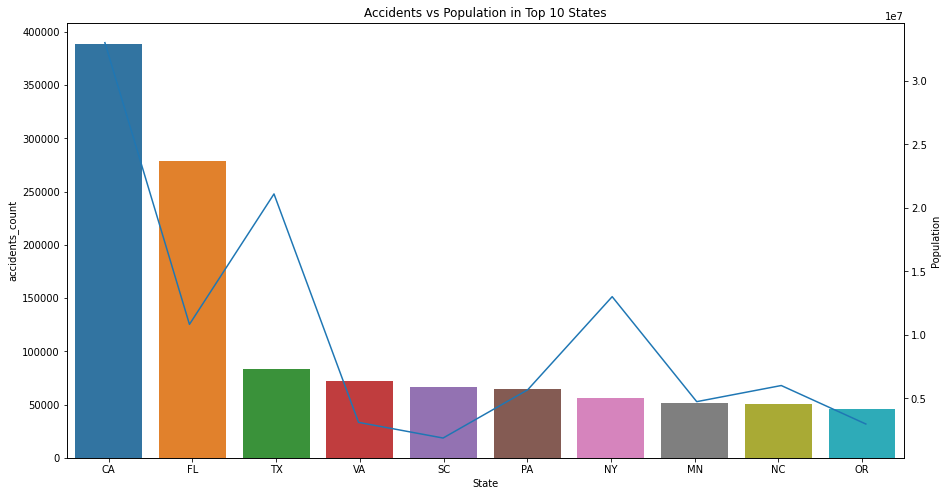

In [ ]:
#plot accident count vs population for the top 10 states
state_acc_count_2021_pd_with_pop = state_acc_count_2021_with_pop.toPandas()
state_acc_count_2021_pd_with_pop = state_acc_count_2021_pd_with_pop[['State','sum(Population)','accidents_count']]
state_acc_count_2021_pd_with_pop.columns = ['State','State2','Population','accidents_count']
state_acc_count_2021_pd_with_pop = state_acc_count_2021_pd_with_pop.sort_values(by=['accidents_count'], ascending=False)



plt.figure(figsize=(15,8))

dfLstack = state_acc_count_2021_pd_with_pop
dfTstack = state_acc_count_2021_pd_with_pop

# plot first graph
ax = sns.barplot(y='accidents_count', x='State',
                 data=dfLstack)

# create second independent axes overlayed on the first
# is is important to use a different label
ax2 = ax.figure.add_subplot(111, label='line')

# plot second graph
sns.lineplot(y='Population', x='State', data=dfTstack,
             palette='pastel', ax=ax2, legend=False)

# align the x-axis, remove the background, (re)move the ticks
# barplot has a xlim from -0.5 to n+0.5
#ax2.set_xlim(dfT['date'].min()-0.5, dfT['date'].max()+0.5)
# remove white background
ax2.set_facecolor('None')
# remove duplicated x-axis (check first that it is properly aligned)
ax2.xaxis.set_visible(False)
# move the y-ticks to the right
ax2.yaxis.tick_right()
#ax2.ylabel.tick_right()
ax2.yaxis.set_label_position("right")
plt.title('Accidents vs Population in Top 10 States')
plt.show()

# 4. Top 10 cities Accident count vs population in the year 2021

In [ ]:
#Spark INNER join of population dataset of top 10 cities with accident count of cities in the year 2021
population_dataset_state_df = population_dataset.groupBy("State", "City").agg(sum("Population"))
state_acc_count_2021_with_pop = population_dataset_state_df.join(city_acc_count_2021, on=['State','City'] ,how='inner') 
state_acc_count_2021_with_pop.count()

10

In [ ]:
state_acc_count_2021_with_pop.show()

+-----+-----------+---------------+----------+--------------------+
|State|       City|sum(Population)|Start_Year|accidents_count_city|
+-----+-----------+---------------+----------+--------------------+
|   FL|    Orlando|         307573|      2021|               41608|
|   TN|  Nashville|         689447|      2021|               13312|
|   NC|    Raleigh|         467665|      2021|               15285|
|   NC|  Charlotte|         874579|      2021|               15635|
|   TX|    Houston|        2304580|      2021|               21475|
|   CA| Sacramento|         524943|      2021|               15848|
|   TX|     Dallas|        1304379|      2021|               24875|
|   FL|      Miami|         442241|      2021|               78875|
|   CA|  San Diego|        1386932|      2021|               13776|
|   CA|Los Angeles|        3898747|      2021|               32768|
+-----+-----------+---------------+----------+--------------------+



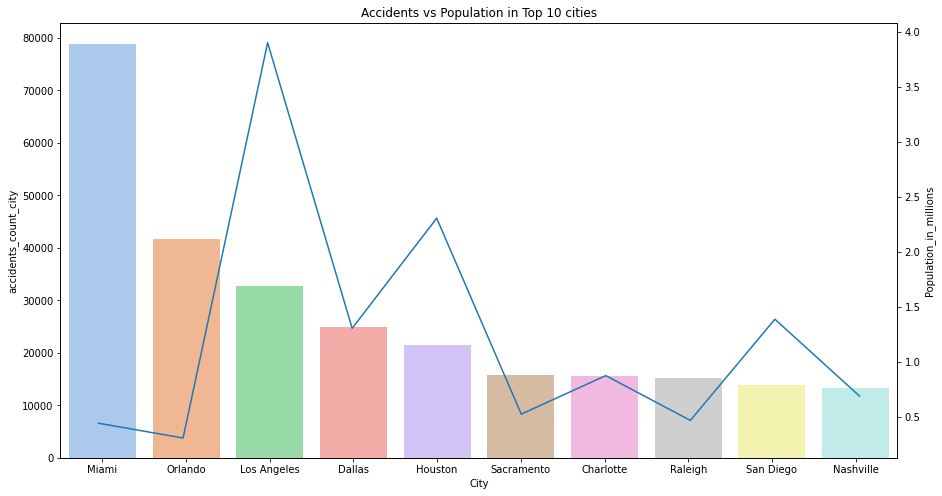

In [ ]:
#plot accident count vs population for the top 10 cities
plt.figure(figsize=(15,8))
city_acc_count_2021_pd_with_pop = state_acc_count_2021_with_pop.toPandas()
city_acc_count_2021_pd_with_pop['Population_in_millions'] = city_acc_count_2021_pd_with_pop['sum(Population)'].apply(lambda x: x/1000000)
city_acc_count_2021_pd_with_pop = city_acc_count_2021_pd_with_pop.sort_values(by=['accidents_count_city'],ascending=False)

dfLstack = city_acc_count_2021_pd_with_pop
dfTstack = city_acc_count_2021_pd_with_pop

# plot first graph
ax = sns.barplot(y='accidents_count_city', x='City',
                 data=dfLstack, palette='pastel')

# create second independent axes overlayed on the first
# is is important to use a different label
ax2 = ax.figure.add_subplot(111, label='line')

# plot second graph
sns.lineplot(y='Population_in_millions', x='City', data=dfTstack,
             palette='pastel', ax=ax2, legend=False)

# align the x-axis, remove the background, (re)move the ticks
# barplot has a xlim from -0.5 to n+0.5
#ax2.set_xlim(dfT['date'].min()-0.5, dfT['date'].max()+0.5)
# remove white background
ax2.set_facecolor('None')
# remove duplicated x-axis (check first that it is properly aligned)
ax2.xaxis.set_visible(False)
# move the y-ticks to the right
ax2.yaxis.tick_right()
#ax2.ylabel.tick_right()
ax2.yaxis.set_label_position("right")
plt.title('Accidents vs Population in Top 10 cities')
plt.show()

# 5. YOY Percentage change in accidents 

# 5.1 Distribution of accidents in US from years 2016 - 2021

In [ ]:
US_acc_count = sqlContext.sql(
    "SELECT Start_Year,'US', sum(accidents_count) as US_accidents_count FROM data_state_acc_count group by Start_Year order by US_accidents_count desc"
)
US_acc_count.show()

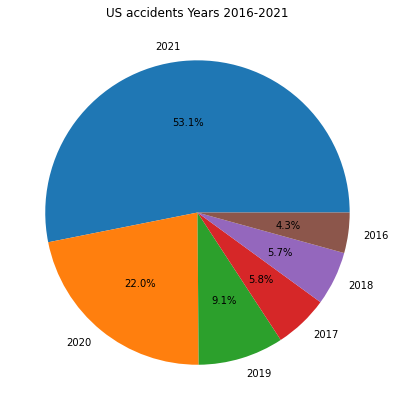

In [ ]:
#pie chart of distribution of accidents in US in years 2016 - 2021 
US_acc_count_pd = US_acc_count.toPandas()

myexplode = [0, 0, 0, 0, 0, 0]
plt.figure(figsize=(7, 7))
plt.pie(
    US_acc_count_pd.US_accidents_count,
    labels=US_acc_count_pd.Start_Year,
    autopct="%0.01f%%",
    explode=myexplode,
)
plt.title("US accidents Years 2016-2021")
plt.show()

In [ ]:
# Using Window function parition by to compute yoy percentage change in accidents in US
from pyspark.sql.window import Window
import pyspark.sql.functions as F

W = Window.partitionBy("US").orderBy("Start_Year")

result_all2 = (
    US_acc_count.withColumn(
        "US_accidents_y-1", F.lag(US_acc_count["US_accidents_count"]).over(W)
    )
    .withColumn(
        "yoy_increase", (F.col("US_accidents_count")) - F.col("US_accidents_y-1")
    )
    .withColumn(
        "yoy_pct_chng",
        (F.col("US_accidents_count") / F.col("US_accidents_y-1") - 1) * 100,
    )
)
result_all2.show()

+----------+---+------------------+----------------+------------+-------------------+
|Start_Year| US|US_accidents_count|US_accidents_y-1|yoy_increase|       yoy_pct_chng|
+----------+---+------------------+----------------+------------+-------------------+
|      2016| US|            122024|            null|        null|               null|
|      2017| US|            163918|          122024|       41894|  34.33259031010294|
|      2018| US|            163176|          163918|        -742|-0.4526653570687822|
|      2019| US|            258615|          163176|       95439|  58.48838064421238|
|      2020| US|            625864|          258615|      367249| 142.00607080022428|
|      2021| US|           1511745|          625864|      885881| 141.54528779415335|
+----------+---+------------------+----------------+------------+-------------------+



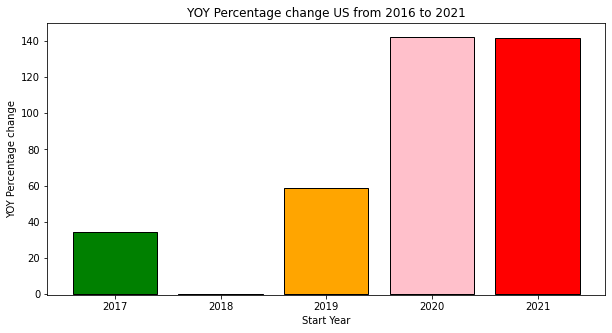

In [ ]:
# Plot the yoy percentage change in accidents in US
result_all2_pd = result_all2.toPandas()
plt.figure(figsize=(10, 5))
plt.bar(
    result_all2_pd.Start_Year,
    result_all2_pd.yoy_pct_chng,
    color=["red", "green", "blue", "orange", "pink"],
    edgecolor="black",
)
plt.ylim(-0.5, 150)
plt.ylabel("YOY Percentage change")
plt.xlabel("Start Year")
plt.title("YOY Percentage change US from 2016 to 2021")
plt.show()

In [ ]:
# Using Window function parition by to compute yoy percentage change in accidents per State
from pyspark.sql.window import Window
import pyspark.sql.functions as F

W = Window.partitionBy("State").orderBy("Start_Year")

state_result_all2_df = (
    data_state_acc_count.withColumn(
        "accidents_y-1", F.lag(data_state_acc_count["accidents_count"]).over(W)
    )
    .withColumn("yoy_increase", (F.col("accidents_count")) - F.col("accidents_y-1"))
    .withColumn(
        "yoy_pct_chng", (F.col("accidents_count") / F.col("accidents_y-1") - 1) * 100
    )
)
state_result_all2_df.show()

+----------+-----+---------------+-------------+------------+-------------------+
|Start_Year|State|accidents_count|accidents_y-1|yoy_increase|       yoy_pct_chng|
+----------+-----+---------------+-------------+------------+-------------------+
|      2016|   AL|            133|         null|        null|               null|
|      2017|   AL|            600|          133|         467|  351.1278195488722|
|      2018|   AL|            935|          600|         335| 55.833333333333336|
|      2019|   AL|           1036|          935|         101| 10.802139037433145|
|      2020|   AL|           5016|         1036|        3980| 384.16988416988414|
|      2021|   AL|          11602|         5016|        6586| 131.29984051036683|
|      2016|   AR|             26|         null|        null|               null|
|      2017|   AR|             62|           26|          36| 138.46153846153845|
|      2018|   AR|            388|           62|         326|  525.8064516129032|
|      2019|   A

# 5.2 States contributing to most accident count YOY

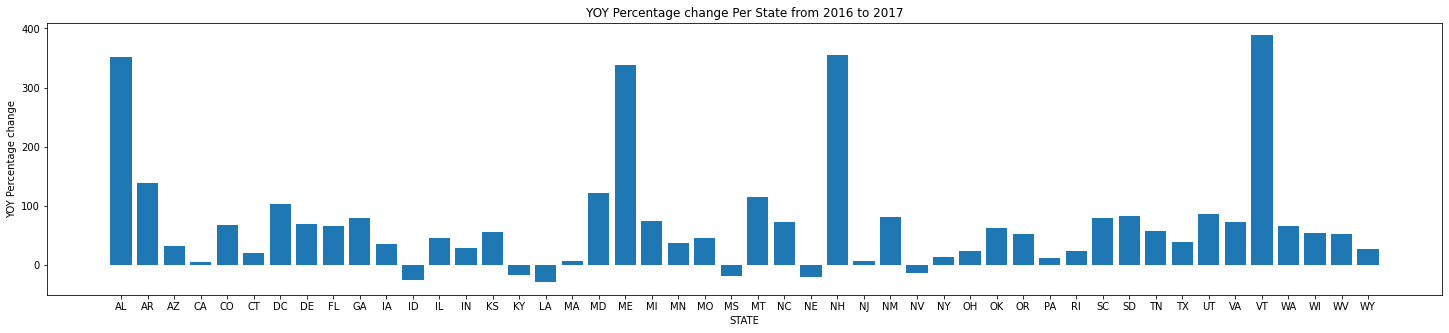

In [ ]:
# Plot the yoy states accident count percentage increase 
state_result_all2_df = state_result_all2_df.toPandas()
state_result_all2_df_2017 = state_result_all2_df[
    state_result_all2_df.Start_Year == 2017
]
fig = px.choropleth(
    state_result_all2_df_2017,
    locations="State",
    locationmode="USA-states",
    color="yoy_pct_chng",
    color_continuous_scale="Viridis_r",
    scope="usa",
    title="Percentage increase from 2016 to 2017",
)

fig.show()
# Plot YOY Percentage change Per State from 2016 to 2017

plt.figure(figsize=(25, 5))
plt.bar(state_result_all2_df_2017.State, state_result_all2_df_2017.yoy_pct_chng)

plt.ylabel("YOY Percentage change")
plt.xlabel("STATE")
plt.title("YOY Percentage change Per State from 2016 to 2017")
plt.show()

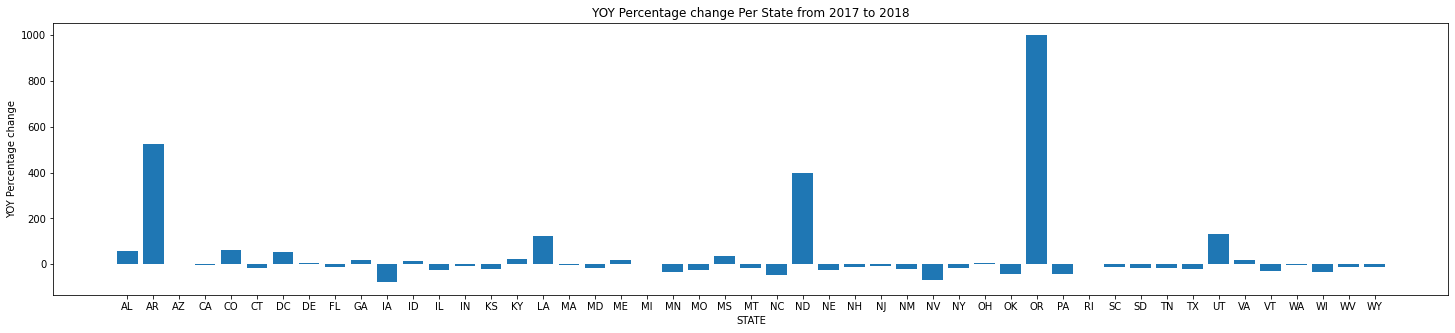

In [ ]:
state_result_all2_df_2018 = state_result_all2_df[
    state_result_all2_df.Start_Year == 2018
]
# Plot the yoy states accident count percentage increase 
fig = px.choropleth(
    state_result_all2_df_2018,
    locations="State",
    locationmode="USA-states",
    color="yoy_pct_chng",
    color_continuous_scale="Viridis_r",
    scope="usa",
    title="Percentage increase from 2017 to 2018",
)

# Plot YOY Percentage change Per State from 2017 to 2018
fig.show()
plt.figure(figsize=(25, 5))
plt.bar(state_result_all2_df_2018.State, state_result_all2_df_2018.yoy_pct_chng)

plt.ylabel("YOY Percentage change")
plt.xlabel("STATE")
plt.title("YOY Percentage change Per State from 2017 to 2018")
plt.show()

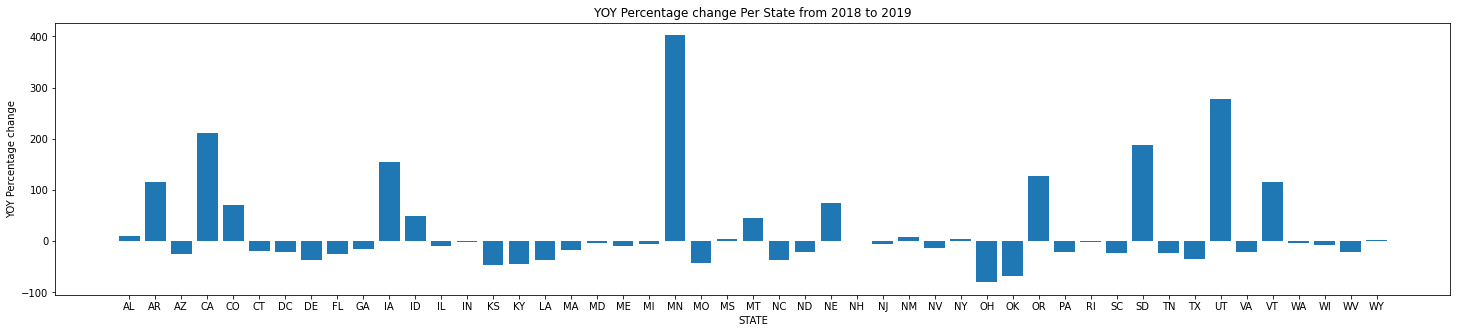

In [ ]:
state_result_all2_df_2019 = state_result_all2_df[
    state_result_all2_df.Start_Year == 2019
]
# Plot the yoy states accident count percentage increase 
# Plot YOY Percentage change Per State from 2018 to 2019
fig = px.choropleth(
    state_result_all2_df_2019,
    locations="State",
    locationmode="USA-states",
    color="yoy_pct_chng",
    color_continuous_scale="Viridis_r",
    scope="usa",
    title="Percentage increase from 2018 to 2019",
)

fig.show()

plt.figure(figsize=(25, 5))
plt.bar(state_result_all2_df_2019.State, state_result_all2_df_2019.yoy_pct_chng)

plt.ylabel("YOY Percentage change")
plt.xlabel("STATE")
plt.title("YOY Percentage change Per State from 2018 to 2019")
plt.show()

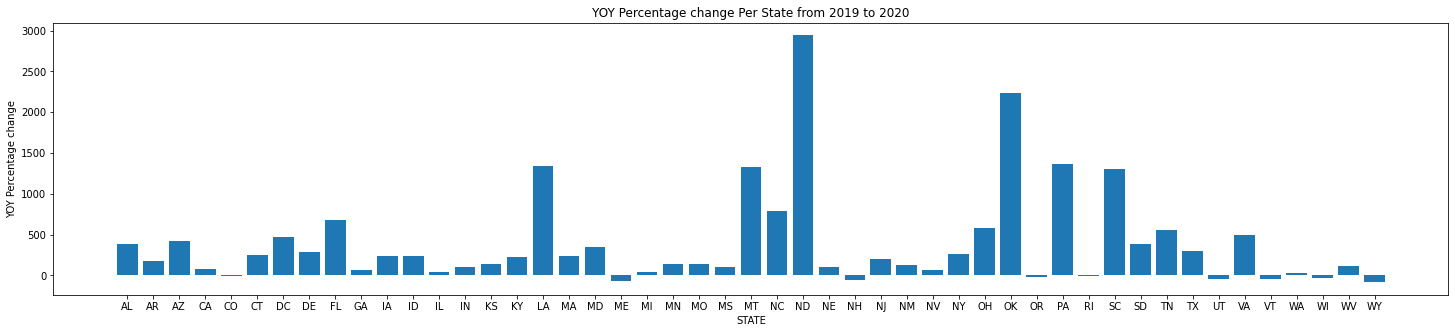

In [ ]:
state_result_all2_df_2020 = state_result_all2_df[
    state_result_all2_df.Start_Year == 2020
]
# Plot the yoy states accident count percentage increase 
# Plot YOY Percentage change Per State from 2019 to 2020
fig = px.choropleth(
    state_result_all2_df_2020,
    locations="State",
    locationmode="USA-states",
    color="yoy_pct_chng",
    color_continuous_scale="Viridis_r",
    scope="usa",
    title="Percentage increase from 2019 to 2020",
)

fig.show()

plt.figure(figsize=(25, 5))
plt.bar(state_result_all2_df_2020.State, state_result_all2_df_2020.yoy_pct_chng)

plt.ylabel("YOY Percentage change")
plt.xlabel("STATE")
plt.title("YOY Percentage change Per State from 2019 to 2020")
plt.show()

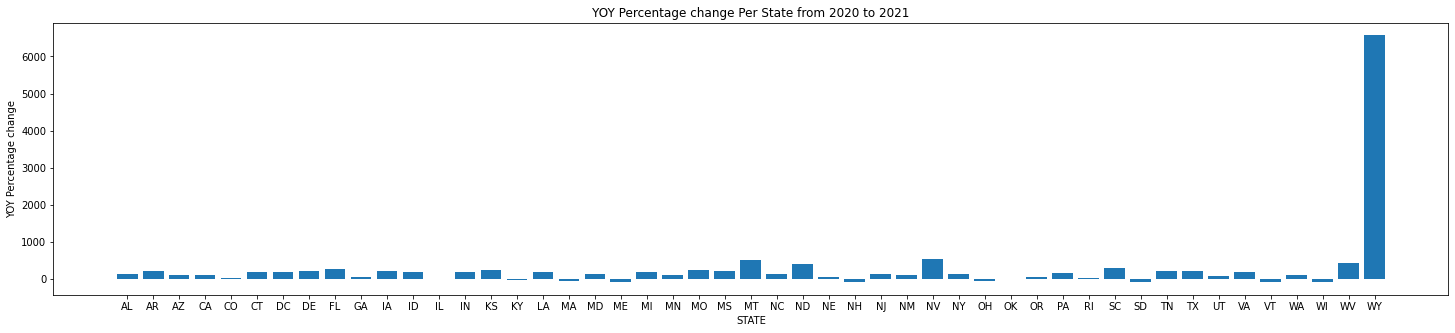

In [ ]:
state_result_all2_df_2021 = state_result_all2_df[
    state_result_all2_df.Start_Year == 2021
]
# Plot the yoy states accident count percentage increase 
# Plot YOY Percentage change Per State from 2020 to 2021
fig = px.choropleth(
    state_result_all2_df_2021,
    locations="State",
    locationmode="USA-states",
    color="yoy_pct_chng",
    color_continuous_scale="Viridis_r",
    scope="usa",
    title="Percentage increase from 2020 to 2021",
)

fig.show()

plt.figure(figsize=(25, 5))
plt.bar(state_result_all2_df_2021.State, state_result_all2_df_2021.yoy_pct_chng)

plt.ylabel("YOY Percentage change")
plt.xlabel("STATE")
plt.title("YOY Percentage change Per State from 2020 to 2021")
plt.show()

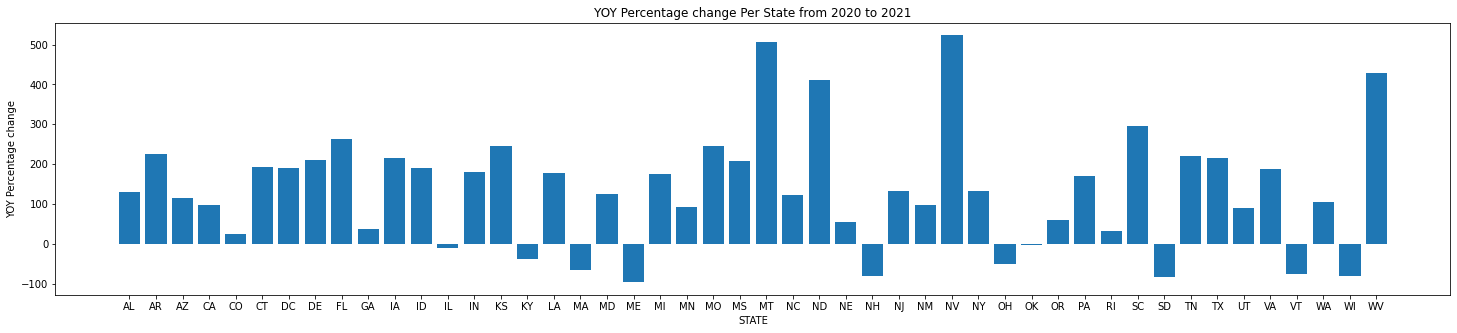

In [ ]:
#Removing the state Wyoming to see the next top states 
state_result_all2_df_2021_v2 = state_result_all2_df_2021[
    state_result_all2_df_2021.State != "WY"
]

fig = px.choropleth(
    state_result_all2_df_2021_v2,
    locations="State",
    locationmode="USA-states",
    color="yoy_pct_chng",
    color_continuous_scale="Viridis_r",
    scope="usa",
    title="Percentage increase from 2020 to 2021",
)

fig.show()

plt.figure(figsize=(25, 5))
plt.bar(state_result_all2_df_2021_v2.State, state_result_all2_df_2021_v2.yoy_pct_chng)

plt.ylabel("YOY Percentage change")
plt.xlabel("STATE")
plt.title("YOY Percentage change Per State from 2020 to 2021")
plt.show()

# 6. Impact of Road conditions/ Presence of various road signs on Accidents

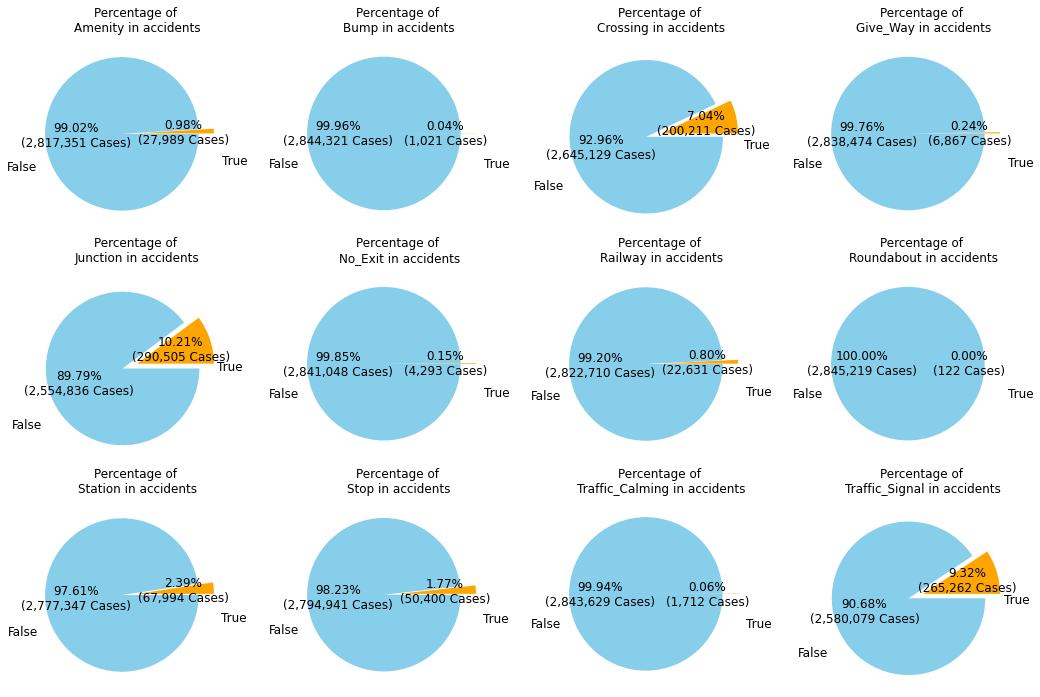

In [ ]:
#Pie chart of impact of raod conditions on accidents

df = accidents_df


def helper_function(x, values):
    num_cases = int(x / 100 * np.sum(values))
    return "{:.2f}%\n({:,d} Cases)".format(x, num_cases)


plt.figure(figsize=(18, 12))
road_conditions = df.columns[30:43]
road_conditions = [None] + road_conditions


for i in range(1, 13):
    plt.subplot(3, 4, i)

    temp = df.groupBy(road_conditions[i]).count().collect()
    count_values = [j["count"] for j in temp]
    actual_values = [j[road_conditions[i]] for j in temp]

    plt.pie(
        count_values,
        labels=["\n\n\n\n" + str(j) for j in actual_values],
        colors=["orange", "skyblue"],
        autopct=lambda x: helper_function(x, count_values),
        labeldistance=1.1,
        textprops={"fontsize": 12},
        explode=[0, 0.2],
    )

    plt.title("Percentage of \n" + road_conditions[i] + " in accidents")


plt.show()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:229: FutureWarning:

Deprecated in 2.0, use createOrReplaceTempView instead.



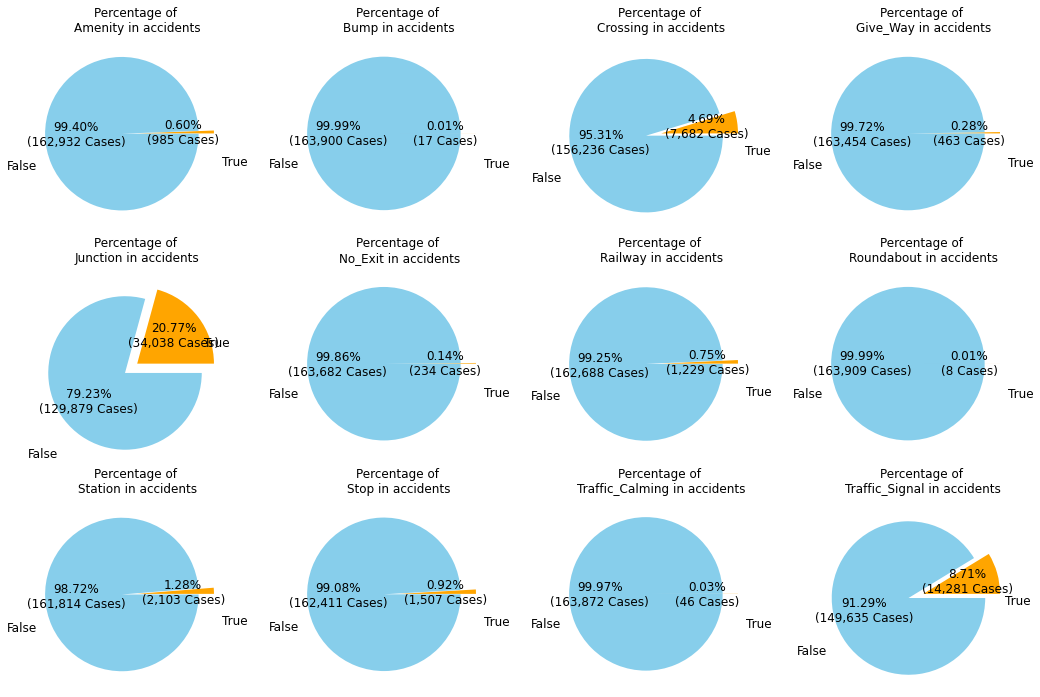

In [ ]:
data_with_year.registerTempTable("data_with_year")
data_with_year_2017 = sqlContext.sql("SELECT * FROM data_with_year where Start_Year == 2017 ")
data_with_year_2017
road_conditions = data_with_year_2017.columns[30:43]
road_conditions

def helper_function(x, values):
    num_cases = int(x / 100 * np.sum(values))
    return "{:.2f}%\n({:,d} Cases)".format(x, num_cases)


plt.figure(figsize=(18, 12))
road_conditions = data_with_year_2017.columns[30:43]
road_conditions = [None] + road_conditions


for i in range(1, 13):
    plt.subplot(3, 4, i)

    temp = data_with_year_2017.groupBy(road_conditions[i]).count().collect()
    count_values = [j["count"] for j in temp]
    actual_values = [j[road_conditions[i]] for j in temp]

    plt.pie(
        count_values,
        labels=["\n\n\n\n" + str(j) for j in actual_values],
        colors=["orange", "skyblue"],
        autopct=lambda x: helper_function(x, count_values),
        labeldistance=1.1,
        textprops={"fontsize": 12},
        explode=[0, 0.2],
    )

    plt.title("Percentage of \n" + road_conditions[i] + " in accidents")


plt.show()

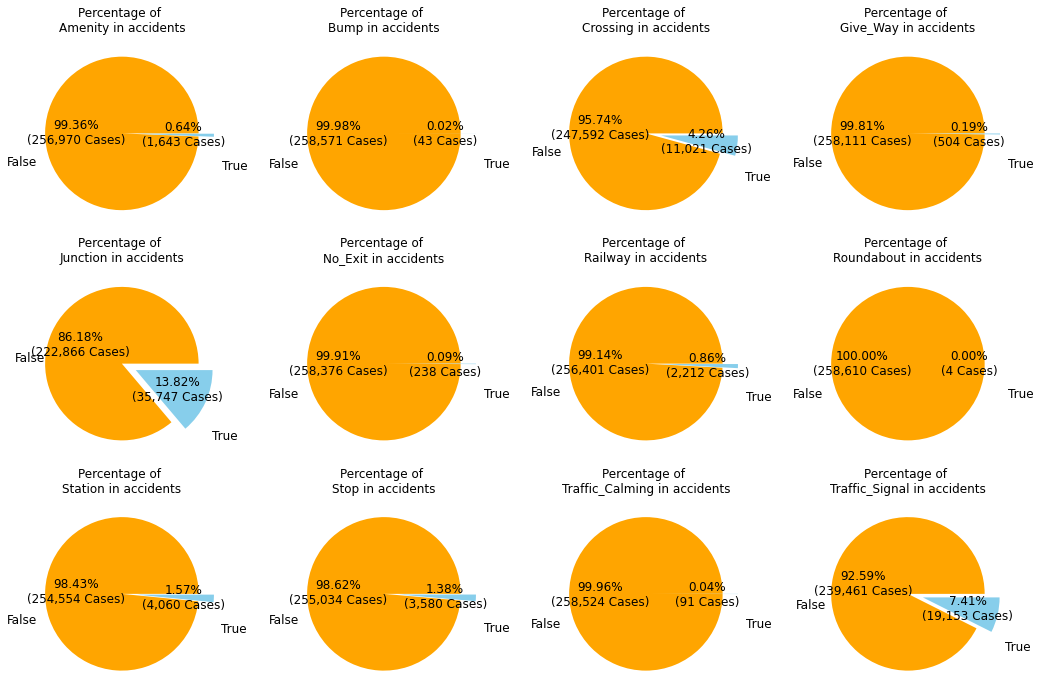

In [ ]:
data_with_year_2019 = sqlContext.sql("SELECT * FROM data_with_year where Start_Year == 2019 ")
data_with_year_2019
road_conditions = data_with_year_2019.columns[30:43]
road_conditions

def helper_function(x, values):
    num_cases = int(x / 100 * np.sum(values))
    return "{:.2f}%\n({:,d} Cases)".format(x, num_cases)


plt.figure(figsize=(18, 12))
road_conditions = data_with_year_2019.columns[30:43]
road_conditions = [None] + road_conditions


for i in range(1, 13):
    plt.subplot(3, 4, i)

    temp = data_with_year_2019.groupBy(road_conditions[i]).count().collect()
    count_values = [j["count"] for j in temp]
    actual_values = [j[road_conditions[i]] for j in temp]

    plt.pie(
        count_values,
        labels=["\n\n\n\n" + str(j) for j in actual_values],
        colors=["orange", "skyblue"],
        autopct=lambda x: helper_function(x, count_values),
        labeldistance=1.1,
        textprops={"fontsize": 12},
        explode=[0, 0.2],
    )

    plt.title("Percentage of \n" + road_conditions[i] + " in accidents")


plt.show()

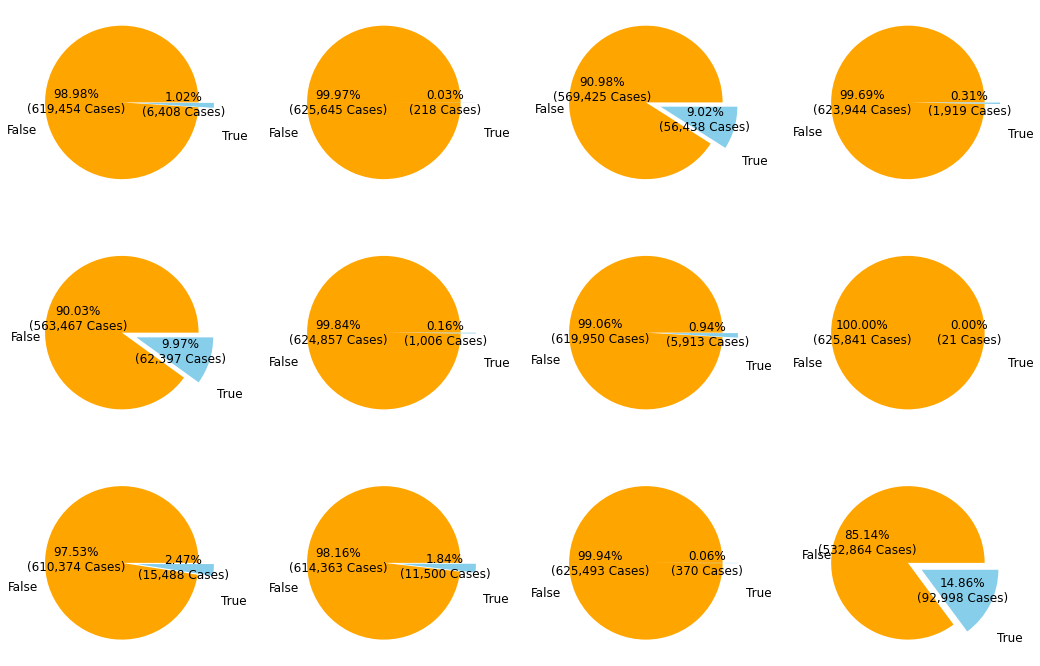

In [ ]:
data_with_year_2020 = sqlContext.sql("SELECT * FROM data_with_year where Start_Year == 2020")
data_with_year_2020
road_conditions = data_with_year_2020.columns[30:43]
road_conditions

def helper_function(x, values):
    num_cases = int(x / 100 * np.sum(values))
    return "{:.2f}%\n({:,d} Cases)".format(x, num_cases)


plt.figure(figsize=(18, 12))
road_conditions = data_with_year_2020.columns[30:43]
road_conditions = [None] + road_conditions


for i in range(1, 13):
    plt.subplot(3, 4, i)

    temp = data_with_year_2020.groupBy(road_conditions[i]).count().collect()
    count_values = [j["count"] for j in temp]
    actual_values = [j[road_conditions[i]] for j in temp]

    plt.pie(
        count_values,
        labels=["\n\n\n\n" + str(j) for j in actual_values],
        colors=["orange", "skyblue"],
        autopct=lambda x: helper_function(x, count_values),
        labeldistance=1.1,
        textprops={"fontsize": 12},
        explode=[0, 0.2],
    )

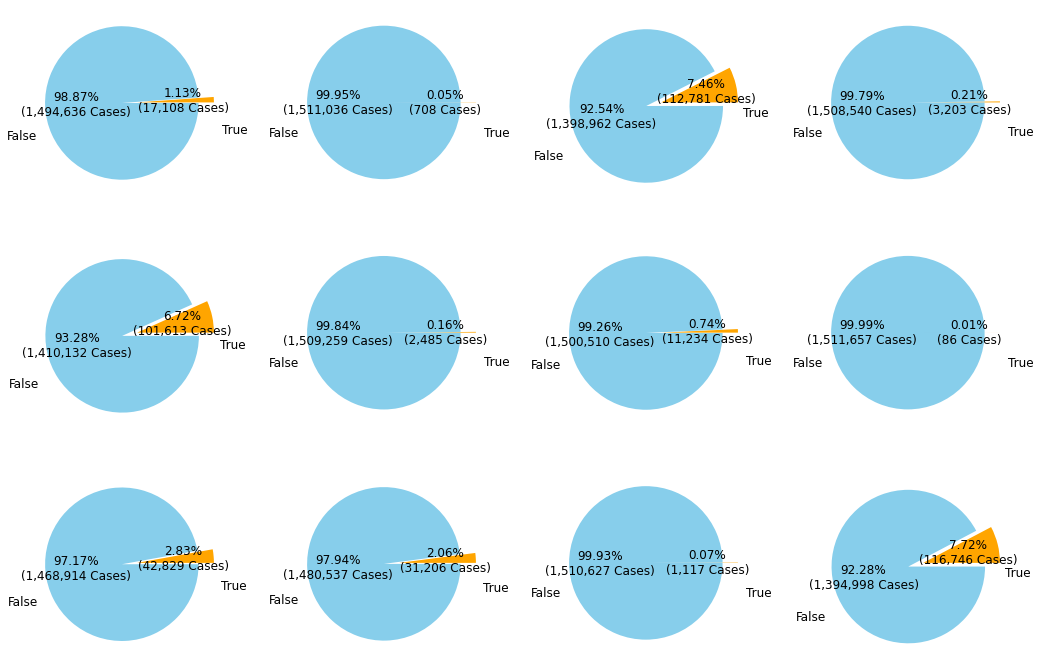

In [ ]:
data_with_year_2021 = sqlContext.sql("SELECT * FROM data_with_year where Start_Year == 2021 ")
data_with_year_2021
road_conditions = data_with_year_2021.columns[30:43]
road_conditions

def helper_function(x, values):
    num_cases = int(x / 100 * np.sum(values))
    return "{:.2f}%\n({:,d} Cases)".format(x, num_cases)


plt.figure(figsize=(18, 12))
road_conditions = data_with_year_2021.columns[30:43]
road_conditions = [None] + road_conditions


for i in range(1, 13):
    plt.subplot(3, 4, i)

    temp = data_with_year_2021.groupBy(road_conditions[i]).count().collect()
    count_values = [j["count"] for j in temp]
    actual_values = [j[road_conditions[i]] for j in temp]

    plt.pie(
        count_values,
        labels=["\n\n\n\n" + str(j) for j in actual_values],
        colors=["orange", "skyblue"],
        autopct=lambda x: helper_function(x, count_values),
        labeldistance=1.1,
        textprops={"fontsize": 12},
        explode=[0, 0.2],
    )

# 7. Impact of Time of Day on Accidents


In [ ]:
# Add hour, month and day_of_week columns

accidents_df = accidents_df.withColumn('hour', substring(col("End_Time").cast("String"), 12, 2)).withColumn('month', substring(col("End_Time").cast("String"), 6, 2))
accidents_df = accidents_df.withColumn('day_of_week', dayofweek(accidents_df.End_Time))

accidents_df.show(5)

+---+--------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------+-----------+----+----------+----------+-----+-------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+-----+-----------+
| ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|           End_Lat|           End_Lng|       Distance(mi)|         Description|Number|     Street|Side|      City|    County|State|Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Dire

### Accident and hour of day

In [ ]:
# Getting the number of accidents and average severity of accidents per hour
hour_count_df = accidents_df.groupBy("Hour").agg(count("ID").alias("Accident_Count"), avg("Severity").alias("Severity_Average")).sort("hour")

In [ ]:
hour_count_df.show(24)

+----+--------------+------------------+
|Hour|Accident_Count|  Severity_Average|
+----+--------------+------------------+
|  00|        105140|2.1671390526916494|
|  01|         90309|2.1617336035168147|
|  02|         79928| 2.141177059353418|
|  03|         69715| 2.136125654450262|
|  04|         59347|2.1689554653141694|
|  05|         52151| 2.214089854461084|
|  06|         56587| 2.220156573064485|
|  07|         73832|2.1756284537869757|
|  08|         99279|2.1464559473806144|
|  09|        106745|2.1380298843037147|
|  10|         96070|2.1411678984074114|
|  11|         93334|2.1632416911307777|
|  12|        107124| 2.157658414547627|
|  13|        127478|2.1460251965044947|
|  14|        143896|2.1326791571690666|
|  15|        162249|2.1205985861237973|
|  16|        188851|2.1093613483645837|
|  17|        214071|  2.10020507214896|
|  18|        223635|2.0993136137008968|
|  19|        192132| 2.104740490912498|
|  20|        150224| 2.121944562786239|
|  21|        12

In [ ]:
hour_count_df_pd = hour_count_df.toPandas()

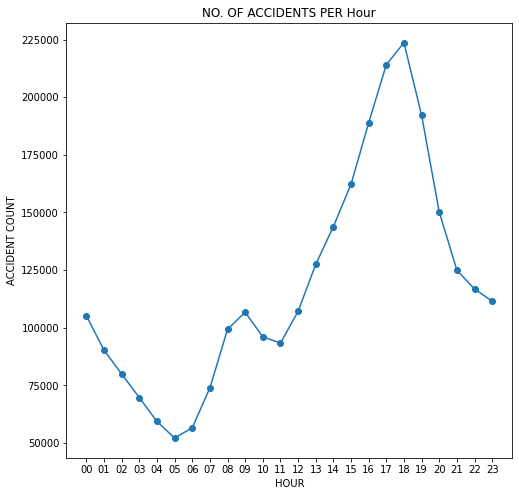

In [ ]:
# Plot

plt.figure(figsize=(8, 8))
plt.plot(hour_count_df_pd.Hour, hour_count_df_pd.Accident_Count, marker = 'o')

plt.xlabel("HOUR")
plt.ylabel("ACCIDENT COUNT")
plt.title("NO. OF ACCIDENTS PER Hour")
plt.show()

###Accidents and section of day

In [ ]:
# Creating a udf to divide the day into 4 hour sections using the logic below
# The reason that we have prefixed the sections with a number is so that when we call sort()
# It sorts them based on how we have labeled them, and we don't have to write a custom sort function

def day_section(hour):
  hour = int(hour)
  section = '2-morning'
  if 12 < hour <= 16:
    section = '3-afternoon'
  elif 16 < hour <= 20:
    section = '4-evening'
  elif 20 < hour <= 23 or hour == 0:
    section = '5-night'
  elif 0 < hour <= 4:
    section = '6-late_night'
  elif 4 < hour <= 8:
    section = '1-early_morning'
  return section

day_section_udf = udf(day_section, StringType())

In [ ]:
# Adding the column section based on the hour column
hour_count_df = hour_count_df.withColumn("section", day_section_udf(col('hour')))


In [ ]:
hour_count_df.show(24)

+----+--------------+------------------+---------------+
|Hour|Accident_Count|  Severity_Average|        section|
+----+--------------+------------------+---------------+
|  00|        105140|2.1671390526916494|        5-night|
|  01|         90309|2.1617336035168147|   6-late_night|
|  02|         79928| 2.141177059353418|   6-late_night|
|  03|         69715| 2.136125654450262|   6-late_night|
|  04|         59347|2.1689554653141694|   6-late_night|
|  05|         52151| 2.214089854461084|1-early_morning|
|  06|         56587| 2.220156573064485|1-early_morning|
|  07|         73832|2.1756284537869757|1-early_morning|
|  08|         99279|2.1464559473806144|1-early_morning|
|  09|        106745|2.1380298843037147|      2-morning|
|  10|         96070|2.1411678984074114|      2-morning|
|  11|         93334|2.1632416911307777|      2-morning|
|  12|        107124| 2.157658414547627|      2-morning|
|  13|        127478|2.1460251965044947|    3-afternoon|
|  14|        143896|2.13267915

In [ ]:
# Getting the accident count and average severity per section of day from the already aggregated dataframe per hour
# Calculating the total number of accidents just includes a groupBy and sum
# But calculating the average requires 2 steps: First to multiply average severity per hour with accident count per hour
# And then finally dividing that with the total accident count per section

section_df = hour_count_df.groupBy('section').agg(sum("Accident_Count").alias("Accident_Count"), sum(col("Severity_Average") * col("Accident_Count")).alias("Severity_Intermediate"))
section_df = section_df.withColumn("Severity_Average", col("Severity_Intermediate")/col("Accident_Count")).drop("Severity_Intermediate")
section_df = section_df.sort("section")
section_df.show()

+---------------+--------------+------------------+
|        section|Accident_Count|  Severity_Average|
+---------------+--------------+------------------+
|1-early_morning|        281849|2.1814091942848832|
|      2-morning|        403273| 2.149826544301255|
|    3-afternoon|        622474|2.1251891645273537|
|      4-evening|        780062|2.1052531721837493|
|        5-night|        458385|2.1624158731197576|
|   6-late_night|        299299|2.1517111650890914|
+---------------+--------------+------------------+



In [ ]:
# Removing the number added with the section to aid with sorting
section_df = section_df.withColumn("day_section", pyspark.sql.functions.split(col("section"), '-')[1]).drop("section")

In [ ]:
section_df.show()

+--------------+------------------+-------------+
|Accident_Count|  Severity_Average|  day_section|
+--------------+------------------+-------------+
|        281849|2.1814091942848832|early_morning|
|        403273| 2.149826544301255|      morning|
|        622474|2.1251891645273537|    afternoon|
|        780062|2.1052531721837493|      evening|
|        458385|2.1624158731197576|        night|
|        299299|2.1517111650890914|   late_night|
+--------------+------------------+-------------+



In [ ]:
section_df_pd = section_df.toPandas()

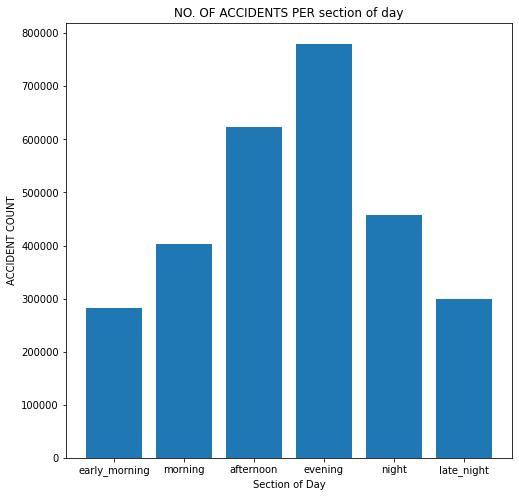

In [ ]:
# Plot

plt.figure(figsize=(8, 8))
plt.bar(section_df_pd.day_section, section_df_pd.Accident_Count)

plt.xlabel("Section of Day")
plt.ylabel("ACCIDENT COUNT")
plt.title("NO. OF ACCIDENTS PER section of day")
plt.show()

### Accidents and month

In [ ]:
# Getting the number of accidents and average severity of accidents per month
month_df = accidents_df.groupBy("month").agg(count("ID").alias("Count"), avg("Severity").alias("Severity_Average")).sort("month")
month_df.show(12)

+-----+------+------------------+
|month| Count|  Severity_Average|
+-----+------+------------------+
|   01|198571|2.1611917148022624|
|   02|195534| 2.145033600294578|
|   03|158186|2.1949477197729257|
|   04|171952| 2.185947241090537|
|   05|181747| 2.196641485141433|
|   06|226502| 2.178002843242002|
|   07|159144|2.1720894284421655|
|   08|178733| 2.157452736763776|
|   09|241498|2.1228374562108177|
|   10|298841| 2.113428210988452|
|   11|360071|2.0951312380058376|
|   12|474563|2.0818795397028422|
+-----+------+------------------+



In [ ]:
month_df_pd = month_df.toPandas()

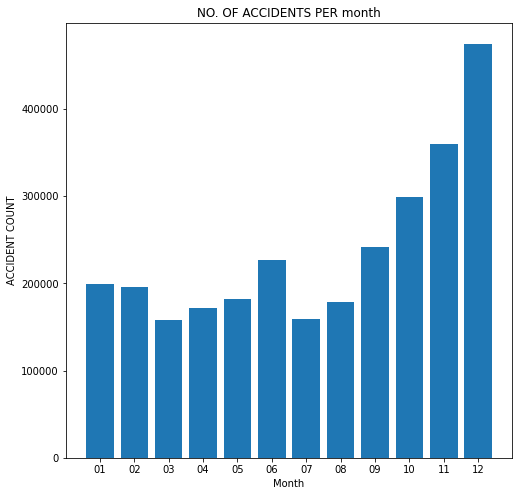

In [ ]:
# Plot

plt.figure(figsize=(8, 8))
plt.bar(month_df_pd.month, month_df_pd.Count)

plt.xlabel("Month")
plt.ylabel("ACCIDENT COUNT")
plt.title("NO. OF ACCIDENTS PER month")
plt.show()

### Accidents v/s day of the week

In [ ]:
# Getting the number of accidents and average severity of accidents per day of the week

day_of_week_df = accidents_df.groupBy("day_of_week").agg(count("ID").alias("Count"), avg("Severity").alias("Severity_Average")).sort("day_of_week")
day_of_week_df.show(7)

+-----------+------+------------------+
|day_of_week| Count|  Severity_Average|
+-----------+------+------------------+
|          1|266789|2.1462466593450253|
|          2|407070|2.1429950622743017|
|          3|441322|2.1421977603654474|
|          4|452867| 2.136152556931726|
|          5|463589| 2.135717197776479|
|          6|486442| 2.132498838504899|
|          7|327263|2.1296449644475546|
+-----------+------+------------------+



In [ ]:
# This is a simple udf to map the numeric day of the week to it's string form
# For example: 1 is Sunday, 2 is Monday and so on

def day_week_string(day):
  day = int(day)
  if day == 1:
    return 'Sunday'
  elif day == 2:
    return 'Monday'
  elif day == 3:
    return 'Tuesday'
  elif day == 4:
    return 'Wednesday'
  elif day == 5:
    return 'Thursday'
  elif day == 6:
    return 'Friday'
  elif day == 7:
    return 'Saturday'
  return ''

day_week_string_udf = udf(day_week_string, StringType())

In [ ]:
day_of_week_df = day_of_week_df.withColumn('day', day_week_string_udf("day_of_week"))

day_of_week_df.show()

+-----------+------+------------------+---------+
|day_of_week| Count|  Severity_Average|      day|
+-----------+------+------------------+---------+
|          1|266789|2.1462466593450253|   Sunday|
|          2|407070|2.1429950622743017|   Monday|
|          3|441322|2.1421977603654474|  Tuesday|
|          4|452867| 2.136152556931726|Wednesday|
|          5|463589| 2.135717197776479| Thursday|
|          6|486442| 2.132498838504899|   Friday|
|          7|327263|2.1296449644475546| Saturday|
+-----------+------+------------------+---------+



In [ ]:
day_of_week_df_pd = day_of_week_df.toPandas()

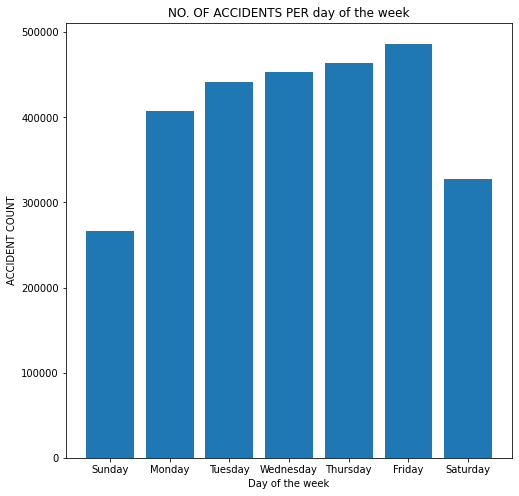

In [ ]:
# Plot

plt.figure(figsize=(8, 8))
plt.bar(day_of_week_df_pd.day, day_of_week_df_pd.Count)

plt.xlabel("Day of the week")
plt.ylabel("ACCIDENT COUNT")
plt.title("NO. OF ACCIDENTS PER day of the week")
plt.show()

### Accident v/s light visibility

In [ ]:
# We use twilight in our report to determine whether it's light outside or dark
# To do so, we will be using Astronomical_Twilight which is the darkest twilight, so that we get the most accurate results
# We will use a simple udf to map Day and Night to Light and Dark

light_or_dark_udf = udf(lambda twilight: "Dark" if twilight == "Night" else "Light")

In [ ]:
# Getting the number of accidents and average severity of accidents based on light visibility

twilight_df = accidents_df.groupBy("Astronomical_Twilight").agg(count("ID").alias("Count"), avg("Severity").alias("Severity_Average")).dropna()
twilight_df = twilight_df.withColumn("visibility", light_or_dark_udf(col("Astronomical_Twilight"))).drop("Astronomical_Twilight")

In [ ]:
twilight_df.show()

+-------+------------------+----------+
|  Count|  Severity_Average|visibility|
+-------+------------------+----------+
| 665492|2.1516997950388586|      Dark|
|2176983| 2.132984961297355|     Light|
+-------+------------------+----------+



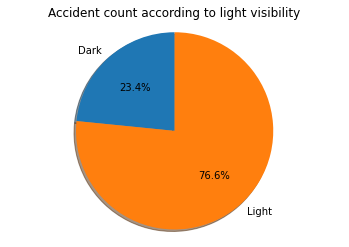

In [ ]:
# Plot
twilight_df_pd = twilight_df.toPandas()

fig1, ax1 = plt.subplots()

ax1.pie(twilight_df_pd.Count, labels = twilight_df_pd.visibility, autopct='%1.1f%%', shadow = True, startangle=90)
ax1.axis('equal')
plt.title('Accident count according to light visibility')
plt.show()

In [ ]:
twilight_df.drop("Count").select("visibility", "Severity_Average").show()

+----------+------------------+
|visibility|  Severity_Average|
+----------+------------------+
|      Dark|2.1516997950388586|
|     Light| 2.132984961297355|
+----------+------------------+



#8. Impact of Weather conditions on accidents

In [ ]:
# Collecting only the weather data
weather_df = accidents_df.select("ID", "Severity", "Start_Time", "End_Time", "Weather_Timestamp", "Temperature(F)",\
                                 "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Direction", "Wind_Speed(mph)",\
                                 "Precipitation(in)", "Weather_Condition")

In [ ]:
weather_df.show(10)

+----+--------+-------------------+-------------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+
|  ID|Severity|         Start_Time|           End_Time|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|
+----+--------+-------------------+-------------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+
| A-1|       3|2016-02-08 00:37:08|2016-02-08 06:37:08|2016-02-08 00:53:00|          42.1|         36.1|       58.0|       29.76|          10.0|            SW|           10.4|              0.0|       Light Rain|
| A-2|       2|2016-02-08 05:56:20|2016-02-08 11:56:20|2016-02-08 05:58:00|          36.9|         null|       91.0|       29.68|          10.0|        

### Correlation of weather factors with severity

In [ ]:
# Calculating correlation for weather factors with respect to severity

corr_dict = {}
cols = weather_df.columns[5:]

for col in cols:
  try:
    corr_dict[col] = weather_df.corr("Severity", col)
  except:
    pass

print(corr_dict)

{'Temperature(F)': -0.04143592554514557, 'Wind_Chill(F)': -0.22130822203850292, 'Humidity(%)': 0.032329895271310624, 'Pressure(in)': 0.005793628201394783, 'Visibility(mi)': 0.0008032389459716829, 'Wind_Speed(mph)': 0.014836907715598991, 'Precipitation(in)': 0.002398429324190474}


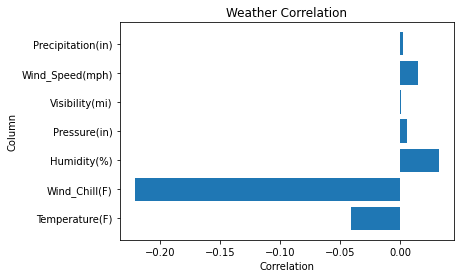

In [ ]:
# Plotting the correlation with respect to severity

y = list(corr_dict.keys())
x = list(corr_dict.values())
plt.barh(y, x)
 
plt.ylabel("Column") 
plt.xlabel("Correlation")
plt.title("Weather Correlation")
plt.show()

### Accident and windchill

In [ ]:
weather_df = weather_df.withColumnRenamed("Temperature(F)", "temperature_f")\
.withColumnRenamed("Wind_Speed(mph)", "wind_speed_mph")\
.withColumnRenamed("Wind_Chill(F)", "wind_chill_f")

In [ ]:
weather_df.show()

+----+--------+-------------------+-------------------+-------------------+-------------+------------+-----------+------------+--------------+--------------+--------------+-----------------+-----------------+
|  ID|Severity|         Start_Time|           End_Time|  Weather_Timestamp|temperature_f|wind_chill_f|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|wind_speed_mph|Precipitation(in)|Weather_Condition|
+----+--------+-------------------+-------------------+-------------------+-------------+------------+-----------+------------+--------------+--------------+--------------+-----------------+-----------------+
| A-1|       3|2016-02-08 00:37:08|2016-02-08 06:37:08|2016-02-08 00:53:00|         42.1|        36.1|       58.0|       29.76|          10.0|            SW|          10.4|              0.0|       Light Rain|
| A-2|       2|2016-02-08 05:56:20|2016-02-08 11:56:20|2016-02-08 05:58:00|         36.9|        null|       91.0|       29.68|          10.0|          Calm|       

In [ ]:
wind_chill_df = weather_df.filter("wind_chill_f IS NOT NULL")

In [ ]:
# Wind chill had the highest correlation. Surprisingly, precipitation did not have a high correlation
# So we try to look into windchill more

# This is a udf to categorize windchill into danger for frostbite
# Source for categorization: Wind chill. (2022, October 6). In Wikipedia. https://en.wikipedia.org/wiki/Wind_chill
# We use the same trick here as earlier of prefixing the category with a number to help with sort

def frostbite_danger(windchill):
  windchill = float(windchill)
  category = '1-little/no'
  if -31 <= windchill < -13:
    category = '2-very_cold'
  elif -70 <= windchill < -31:
    category = '3-danger'
  elif windchill <= -70:
    category = '4-great_danger'
  return category

frostbite_danger_udf = udf(frostbite_danger, StringType())

In [ ]:
# Calculating the average severity based on frost bite danger

frostbite_df = wind_chill_df.withColumn("frostbite_danger_temp", frostbite_danger_udf('wind_chill_f'))
frostbite_df = frostbite_df.groupBy("frostbite_danger_temp").agg(avg("Severity").alias("Severity_Average")).sort("frostbite_danger_temp")
frostbite_df = frostbite_df.withColumn("frostbite_danger", split("frostbite_danger_temp", '-')[1]).drop("frostbite_danger_temp")
frostbite_df.select("frostbite_danger", "Severity_Average").show()

+----------------+------------------+
|frostbite_danger|  Severity_Average|
+----------------+------------------+
|       little/no|2.0890992835425903|
|       very_cold| 2.118330148463913|
|          danger| 2.345622119815668|
|    great_danger|2.3333333333333335|
+----------------+------------------+



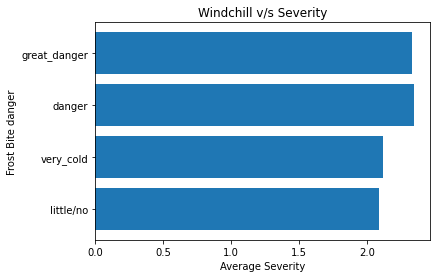

In [ ]:
# Plot

frostbite_df_pd = frostbite_df.toPandas()

y = list(frostbite_df_pd.frostbite_danger)
x = list(frostbite_df_pd.Severity_Average)
plt.barh(y, x)

plt.ylabel("Frost Bite danger")
plt.xlabel("Average Severity")
plt.title("Windchill v/s Severity")
plt.show()

### Accidents and weather conditions

In [ ]:
# Calculating the number of accidents and average severity count based on the Weather_Condition column in the dataset
weather_condition_df = weather_df.groupBy('Weather_Condition').agg(count("ID").alias("Count"), avg("Severity").alias("Severity_Average")).sort(desc("Severity_Average"))
weather_condition_df.show(50)

+--------------------+------+------------------+
|   Weather_Condition| Count|  Severity_Average|
+--------------------+------+------------------+
|  Light Blowing Snow|     2|               4.0|
|  Light Snow Showers|     6|3.6666666666666665|
|Patches of Fog / ...|     4|               3.5|
|           Light Fog|     1|               3.0|
|  Heavy Blowing Snow|     1|               3.0|
|Freezing Rain / W...|     2|               3.0|
|Thunder and Hail ...|     1|               3.0|
|          Light Haze|     1|               3.0|
|        Funnel Cloud|     2|               3.0|
|Heavy Snow with T...|     3|               3.0|
|Heavy Thunderstor...|     3|2.6666666666666665|
|Light Thunderstor...|     6|2.6666666666666665|
|       Smoke / Windy|    46| 2.608695652173913|
|            Overcast| 84882|2.5017082538111732|
|   Heavy Ice Pellets|     2|               2.5|
|Light Thunderstor...|  1089|2.4894398530762167|
|Heavy Thunderstor...|   510| 2.488235294117647|
|  Light Rain Shower

In [ ]:
# Getting the top 20 based on average severity
weather_condition_df_pd = weather_condition_df.limit(20).toPandas()
weather_condition_df_pd = weather_condition_df_pd.astype({"Count": int}) 

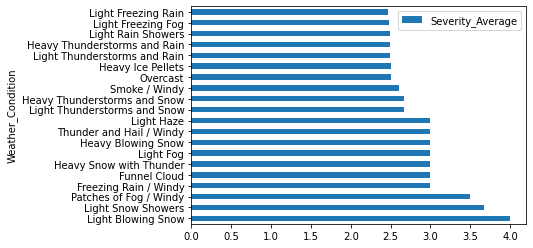

In [ ]:
# Plot
weather_condition_df_pd.plot.barh(x = 'Weather_Condition', y = 'Severity_Average')

# 9. Prediction of Severity of Accidents

In [ ]:
df.groupBy("Severity").count().show()
int_double_booleans = []
for i in df.dtypes:
    if i[1] in ["int", "double", "boolean"]:
        int_double_booleans.append(i[0])
df2 = df[int_double_booleans]
df3 = df2.select([col(c).cast("double") for c in int_double_booleans])

+--------+-------+
|Severity|  count|
+--------+-------+
|       3| 155105|
|       4| 131193|
|       2|2532991|
|       1|  26053|
+--------+-------+



In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

data = df3
data2 = data.na.fill(0)
assembler = VectorAssembler(inputCols=data2.columns[1:], outputCol="features")

data3 = assembler.transform(data2)

data3.select("features", "Severity").show()

+--------------------+--------+
|            features|Severity|
+--------------------+--------+
|(26,[0,1,2,3,4,6,...|     3.0|
|(26,[0,1,2,3,4,6,...|     2.0|
|(26,[0,1,2,3,4,6,...|     2.0|
|(26,[0,1,2,3,4,6,...|     2.0|
|(26,[0,1,2,3,4,6,...|     3.0|
|(26,[0,1,2,3,4,6,...|     2.0|
|(26,[0,1,2,3,4,6,...|     2.0|
|(26,[0,1,2,3,4,6,...|     2.0|
|(26,[0,1,2,3,4,6,...|     2.0|
|(26,[0,1,2,3,4,6,...|     2.0|
|(26,[0,1,2,3,4,6,...|     2.0|
|(26,[0,1,2,3,4,6,...|     2.0|
|(26,[0,1,2,3,4,6,...|     2.0|
|(26,[0,1,2,3,4,6,...|     2.0|
|(26,[0,1,2,3,4,5,...|     3.0|
|(26,[0,1,2,3,4,5,...|     3.0|
|(26,[0,1,2,3,4,6,...|     3.0|
|(26,[0,1,2,3,4,6,...|     2.0|
|(26,[0,1,2,3,4,6,...|     3.0|
|(26,[0,1,2,3,4,6,...|     4.0|
+--------------------+--------+
only showing top 20 rows



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load the data stored in LIBSVM format as a DataFrame.
# data = spark.read.format("libsvm").load("data/mllib/sample_libsvm_data.txt")

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="Severity", outputCol="indexedLabel").fit(data3)
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(
    inputCol="features", outputCol="indexedFeatures", maxCategories=4
).fit(data3)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data3.randomSplit([0.7, 0.3])

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g " % (accuracy))

treeModel = model.stages[2]
# summary only
print(treeModel)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|(26,[0,1,2,3,4,5,...|
|       0.0|         0.0|(26,[0,1,2,3,4,6,...|
|       0.0|         0.0|(26,[0,1,2,3,4,5,...|
|       0.0|         0.0|(26,[0,1,2,3,4,6,...|
|       0.0|         0.0|(26,[0,1,2,3,4,5,...|
+----------+------------+--------------------+
only showing top 5 rows

Test Accuracy = 0.893488 
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_fb5e7cfc92a9, depth=5, numNodes=19, numClasses=4, numFeatures=26
